In [1]:
import os
from pathlib import Path
import random

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

# Detect project root (same pattern as other notebooks)
CWD = Path().resolve()
if CWD.name == "notebooks":
    PROJECT_ROOT = CWD.parent
else:
    PROJECT_ROOT = CWD

print("Current working dir:", CWD)
print("Assumed project root:", PROJECT_ROOT)

# Dataset & models paths
# object_detection_Dataset or object_detection_dataset
candidates = [
    PROJECT_ROOT / "data" / "object_detection_Dataset",
    PROJECT_ROOT / "data" / "object_detection_dataset",
]

DETECTION_DIR = None
for c in candidates:
    if c.exists():
        DETECTION_DIR = c
        break

if DETECTION_DIR is None:
    raise FileNotFoundError(
        f"❌ Could not find object detection dataset in: {candidates}. "
        "Make sure it exists under data/."
    )

print("Using detection dataset path:", DETECTION_DIR)

DETECTION_MODELS_DIR = PROJECT_ROOT / "models" / "detection"
print("Detection models dir:", DETECTION_MODELS_DIR)


Current working dir: F:\Aerial_Object_Classification_Detection\notebooks
Assumed project root: F:\Aerial_Object_Classification_Detection
Using detection dataset path: F:\Aerial_Object_Classification_Detection\data\object_detection_Dataset
Detection models dir: F:\Aerial_Object_Classification_Detection\models\detection


In [2]:
try:
    from ultralytics import YOLO
except ImportError as e:
    raise ImportError(
        "Ultralytics YOLO is not installed. Install it with: pip install ultralytics"
    ) from e

# Default run name used in 06_yolov8_training.ipynb
RUN_NAME = "yolov8n_bird_drone"

run_dir = DETECTION_MODELS_DIR / RUN_NAME
weights_dir = run_dir / "weights"
best_weights = weights_dir / "best.pt"
last_weights = weights_dir / "last.pt"

print("Expected run directory:", run_dir)
print("Expected best weights:", best_weights)

if best_weights.exists():
    weights_path = best_weights
    print("✅ Found best.pt at:", weights_path)
elif last_weights.exists():
    weights_path = last_weights
    print("⚠️ best.pt not found, using last.pt at:", weights_path)
else:
    raise FileNotFoundError(
        f"❌ No best.pt or last.pt found in {weights_dir}. "
        "Run 06_yolov8_training.ipynb first, or check RUN_NAME."
    )

# Load YOLO model
model = YOLO(str(weights_path))
print("✅ YOLOv8 model loaded.")


Expected run directory: F:\Aerial_Object_Classification_Detection\models\detection\yolov8n_bird_drone
Expected best weights: F:\Aerial_Object_Classification_Detection\models\detection\yolov8n_bird_drone\weights\best.pt
✅ Found best.pt at: F:\Aerial_Object_Classification_Detection\models\detection\yolov8n_bird_drone\weights\best.pt
✅ YOLOv8 model loaded.


In [3]:
def run_inference_on_image(img_path, imgsz=640, conf=0.25):
    """
    Runs YOLOv8 inference on a single image path.
    Returns:
      result: ultralytics result object for this image
    """
    img_path = str(img_path)
    print(f"\n📷 Running inference on: {img_path}")
    
    results = model.predict(
        source=img_path,
        imgsz=imgsz,
        conf=conf,
        verbose=False
    )

    # results is a list; we take the first element
    result = results[0]
    print("Detections:", len(result.boxes))
    return result


In [4]:
import cv2

# Class names
CLASS_NAMES = ["bird", "drone"]

def plot_detection(result, figsize=(6, 6)):
    """
    Visualize YOLOv8 detection result using matplotlib.
    """
    # Get original image (numpy array)
    im_array = result.plot()  # this draws boxes on the image
    im_rgb = cv2.cvtColor(im_array, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=figsize)
    plt.imshow(im_rgb)
    plt.axis("off")
    plt.title("YOLOv8 Detection")
    plt.show()

def print_boxes_info(result):
    """
    Print bounding box info: class, confidence, and coordinates.
    """
    boxes = result.boxes
    if boxes is None or len(boxes) == 0:
        print("No boxes detected.")
        return
    
    for i, box in enumerate(boxes):
        cls_id = int(box.cls.cpu().numpy()[0])
        conf = float(box.conf.cpu().numpy()[0])
        xyxy = box.xyxy.cpu().numpy()[0]  # [x1, y1, x2, y2]

        class_name = CLASS_NAMES[cls_id] if cls_id < len(CLASS_NAMES) else str(cls_id)
        print(f"Box {i+1}: Class={class_name}, Conf={conf:.3f}, xyxy={xyxy}")


Test images dir: F:\Aerial_Object_Classification_Detection\data\object_detection_Dataset\test\images exists: True
Number of test images found: 224
Random test image chosen: F:\Aerial_Object_Classification_Detection\data\object_detection_Dataset\test\images\16b566cd5f8b1f86_jpg.rf.28453809797d8f133b23f8e993595b16.jpg

📷 Running inference on: F:\Aerial_Object_Classification_Detection\data\object_detection_Dataset\test\images\16b566cd5f8b1f86_jpg.rf.28453809797d8f133b23f8e993595b16.jpg
Detections: 7
Box 1: Class=bird, Conf=0.712, xyxy=[     36.088      303.16      83.692      366.96]
Box 2: Class=bird, Conf=0.641, xyxy=[     197.84      69.764      263.19      130.18]
Box 3: Class=bird, Conf=0.492, xyxy=[     239.61      72.807      295.99      114.33]
Box 4: Class=bird, Conf=0.410, xyxy=[     211.27      70.857      284.37      127.51]
Box 5: Class=bird, Conf=0.370, xyxy=[     226.52      70.916      294.58      119.81]
Box 6: Class=bird, Conf=0.354, xyxy=[     256.31      72.298      29

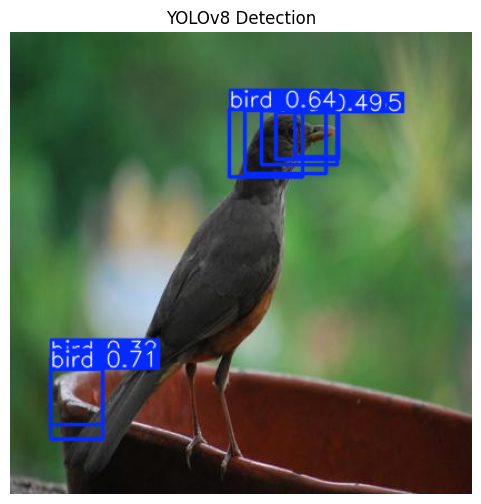

In [5]:
test_images_dir = DETECTION_DIR / "test" / "images"
print("Test images dir:", test_images_dir, "exists:", test_images_dir.exists())

if not test_images_dir.exists():
    raise FileNotFoundError(f"❌ Test images folder not found: {test_images_dir}")

# Get a list of image files
IMAGE_EXTS = {".jpg", ".jpeg", ".png", ".bmp"}

test_image_files = [f for f in test_images_dir.iterdir() if f.suffix.lower() in IMAGE_EXTS]
print("Number of test images found:", len(test_image_files))

if len(test_image_files) == 0:
    raise ValueError("❌ No test images found. Check your test/images folder.")

# Pick a random image
sample_img_path = random.choice(test_image_files)
print("Random test image chosen:", sample_img_path)

# Run inference
result = run_inference_on_image(sample_img_path, imgsz=640, conf=0.25)

# Print detection info
print_boxes_info(result)

# Visualize
plot_detection(result)



📷 Running inference on: F:\Aerial_Object_Classification_Detection\data\object_detection_Dataset\test\images\01d886ab21630a59_jpg.rf.ee35a5536028b87e8c1daa0e0ae9ed06.jpg
Detections: 3
Box 1: Class=bird, Conf=0.598, xyxy=[     228.89      81.921      282.23      143.83]
Box 2: Class=bird, Conf=0.552, xyxy=[     353.01      347.09      415.64      411.83]
Box 3: Class=bird, Conf=0.302, xyxy=[     329.22      341.81      398.08      404.58]


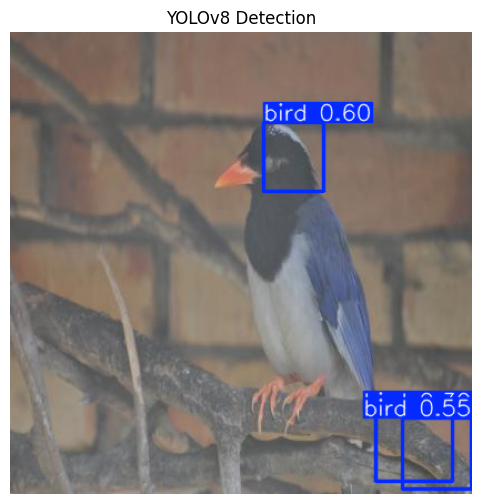


📷 Running inference on: F:\Aerial_Object_Classification_Detection\data\object_detection_Dataset\test\images\1a7ee31df5960b05_jpg.rf.a8e519daa2fb787deec5315ecfd3f470.jpg
Detections: 24
Box 1: Class=bird, Conf=0.625, xyxy=[     146.15      136.97      206.34      199.47]
Box 2: Class=bird, Conf=0.623, xyxy=[     178.61      245.97      194.01      257.62]
Box 3: Class=bird, Conf=0.569, xyxy=[     87.459      83.611      142.07       144.8]
Box 4: Class=bird, Conf=0.568, xyxy=[     45.997      71.156      57.535      80.665]
Box 5: Class=bird, Conf=0.567, xyxy=[     159.55      31.446      172.34      40.675]
Box 6: Class=bird, Conf=0.520, xyxy=[     232.15      231.06      272.75      290.39]
Box 7: Class=bird, Conf=0.515, xyxy=[     333.97      198.17      386.85      260.89]
Box 8: Class=bird, Conf=0.511, xyxy=[     108.86      45.172      122.25      53.563]
Box 9: Class=bird, Conf=0.506, xyxy=[     33.626      82.458      98.869      138.09]
Box 10: Class=bird, Conf=0.496, xyxy=[   

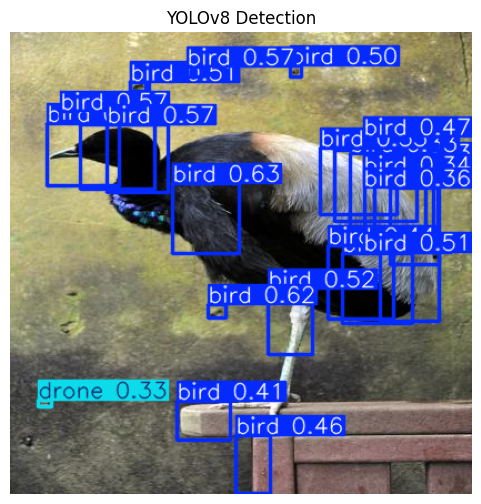


📷 Running inference on: F:\Aerial_Object_Classification_Detection\data\object_detection_Dataset\test\images\12c29100615a16c4_jpg.rf.8aa72d7081144373a4dc1634ecece9a1.jpg
Detections: 9
Box 1: Class=bird, Conf=0.649, xyxy=[      157.9      67.266      226.11      128.67]
Box 2: Class=bird, Conf=0.500, xyxy=[     169.22      67.442      237.73      125.88]
Box 3: Class=bird, Conf=0.468, xyxy=[     105.77      161.18       158.9      219.47]
Box 4: Class=bird, Conf=0.437, xyxy=[     249.75      76.179      291.88      138.02]
Box 5: Class=bird, Conf=0.358, xyxy=[      221.5      77.101       238.6          86]
Box 6: Class=bird, Conf=0.349, xyxy=[     205.05      204.62      260.08      260.78]
Box 7: Class=bird, Conf=0.289, xyxy=[     121.78       116.9      182.03      181.52]
Box 8: Class=bird, Conf=0.289, xyxy=[     240.09      69.209      301.16      132.01]
Box 9: Class=bird, Conf=0.251, xyxy=[      146.9      72.808      211.31      135.16]


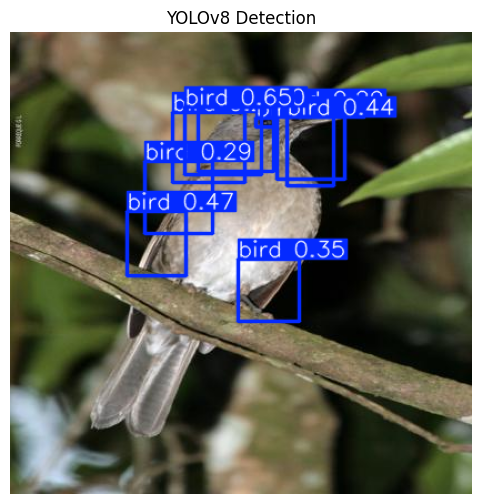

In [6]:
def run_inference_on_multiple_test_images(num_images=5, imgsz=640, conf=0.25):
    num_images = min(num_images, len(test_image_files))
    sample_files = random.sample(test_image_files, num_images)
    
    for img_path in sample_files:
        result = run_inference_on_image(img_path, imgsz=imgsz, conf=conf)
        print_boxes_info(result)
        plot_detection(result)

# Example: run on 3 random test images
run_inference_on_multiple_test_images(num_images=3, imgsz=640, conf=0.25)



📷 Running inference on: C:\Users\LENOVO\OneDrive\Desktop\bird_test_006.jpg
Detections: 8
Box 1: Class=bird, Conf=0.850, xyxy=[     25.494      97.818      59.449      123.15]
Box 2: Class=bird, Conf=0.811, xyxy=[     54.749      103.05      87.085       127.3]
Box 3: Class=bird, Conf=0.805, xyxy=[     75.186      98.059      106.98      122.55]
Box 4: Class=bird, Conf=0.461, xyxy=[     130.61      47.552      156.05      74.472]
Box 5: Class=bird, Conf=0.448, xyxy=[     49.705      102.65      82.041      129.11]
Box 6: Class=bird, Conf=0.405, xyxy=[     64.455      100.41      105.18      124.68]
Box 7: Class=bird, Conf=0.334, xyxy=[     88.016      98.026      108.19      119.98]
Box 8: Class=bird, Conf=0.274, xyxy=[      39.69      101.29      77.514         129]


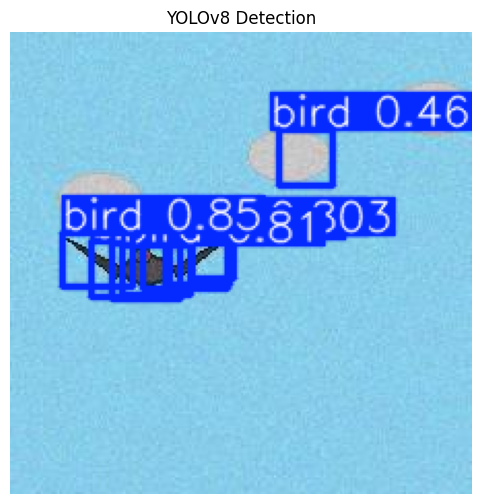

In [14]:
custom_image_path = Path(r"C:\Users\LENOVO\OneDrive\Desktop\bird_test_006.jpg")

if custom_image_path.exists():
    result_custom = run_inference_on_image(str(custom_image_path), imgsz=640, conf=0.25)
    print_boxes_info(result_custom)
    plot_detection(result_custom)
else:
    print("⚠️ Path does not exist:", custom_image_path)
    print("Please paste a VALID image path.")


In [8]:
output_dir = DETECTION_MODELS_DIR / "yolov8n_bird_drone_manual_infer"
output_dir.mkdir(parents=True, exist_ok=True)

print("Output directory for saved images:", output_dir)

# Example: save predictions for first 10 test images
subset_files = [str(p) for p in test_image_files[:10]]

save_results = model.predict(
    source=subset_files,
    imgsz=640,
    conf=0.25,
    project=str(output_dir),
    name="batch",
    exist_ok=True,
    save=True,    # save images with boxes
    save_txt=False
)

print("✅ Saved predictions to:", output_dir / "batch")


Output directory for saved images: F:\Aerial_Object_Classification_Detection\models\detection\yolov8n_bird_drone_manual_infer
Results saved to F:\Aerial_Object_Classification_Detection\models\detection\yolov8n_bird_drone_manual_infer\batch
✅ Saved predictions to: F:\Aerial_Object_Classification_Detection\models\detection\yolov8n_bird_drone_manual_infer\batch
